# Practica 1

In [1]:
library(readxl)
# Para listar las hojas que hay:
# excel_sheets(path="datasets/IngresoUniversidad.xlsx")

exp_ingreso <- read_excel("datasets/IngresoUniversidad.xlsx", sheet="Prueba")

exp_ingreso <- as.data.frame(exp_ingreso)
# Renombramos columna, porque no tiene nombre.
#names(cal_ingreso)[2] <- "sexo"
head(exp_ingreso, n=4)

Expediente,Resultado,Conocimiento,Aptitudes
<dbl>,<dbl>,<dbl>,<dbl>
1,1,596,2.96
2,1,473,3.14
3,1,482,3.22
4,1,527,3.29


In [2]:
library(dplyr)

exp_ingreso %>%
    filter(Resultado %in% c(1,2)) %>%
    select(Resultado, Conocimiento, Aptitudes) %>%
    group_by(Resultado) %>%    
    summary()


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



   Resultado      Conocimiento     Aptitudes    
 Min.   :1.000   Min.   :321.0   Min.   :2.130  
 1st Qu.:1.000   1st Qu.:438.5   1st Qu.:2.495  
 Median :1.000   Median :520.0   Median :3.020  
 Mean   :1.475   Mean   :507.1   Mean   :2.964  
 3rd Qu.:2.000   3rd Qu.:561.0   3rd Qu.:3.395  
 Max.   :2.000   Max.   :693.0   Max.   :3.800  

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


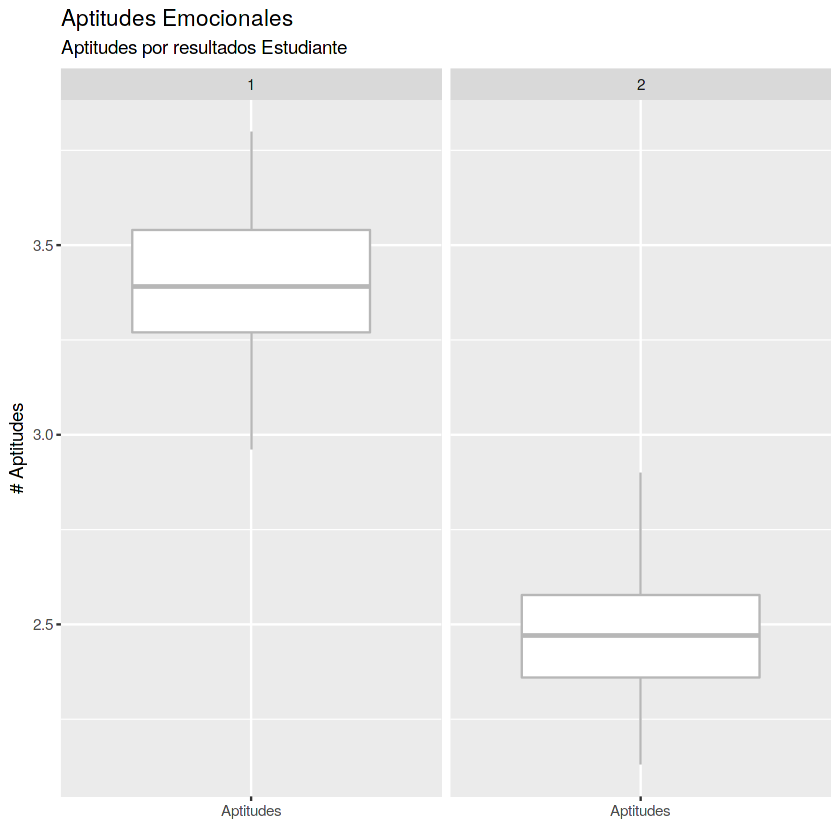

In [3]:
library(tidyr)
library(ggplot2)
exp_ingreso_long <- gather(exp_ingreso, variable, valor, -c(Expediente, Resultado))

exp_ingreso_long %>%
    filter(Resultado %in% c(1,2) & variable=="Aptitudes") %>%    
    ggplot(aes(x=variable, y=valor, label=Resultado))+
        geom_boxplot(color="#B7B7B7")+        
        labs(
            title = "Aptitudes Emocionales"
            ,subtitle = "Aptitudes por resultados Estudiante"
            ,x = element_blank()
            ,y = "# Aptitudes"
        )+
    facet_wrap(.~Resultado)

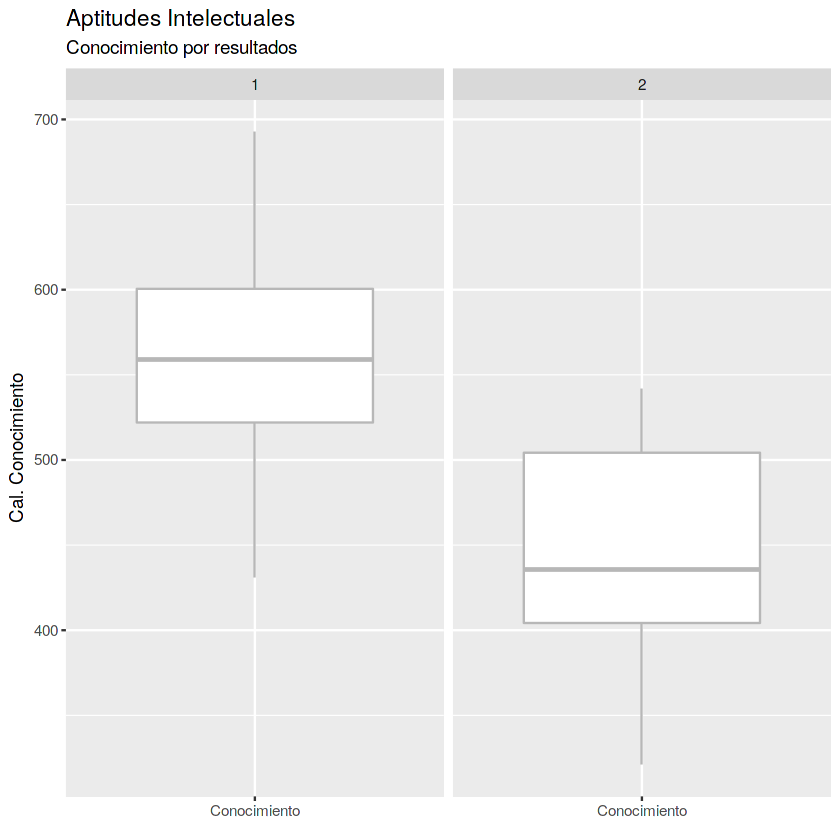

In [4]:
exp_ingreso_long %>%
    filter(Resultado %in% c(1,2) & variable=="Conocimiento") %>%    
    ggplot(aes(x=variable, y=valor, label=Resultado))+
        geom_boxplot(color="#B7B7B7")+        
        labs(
            title = "Aptitudes Intelectuales"
            ,subtitle = "Conocimiento por resultados"
            ,x = element_blank()
            ,y = "Cal. Conocimiento"
        )+
    facet_wrap(.~Resultado)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: 'GGally'

The following object is masked from 'package:dplyr':

    nasa



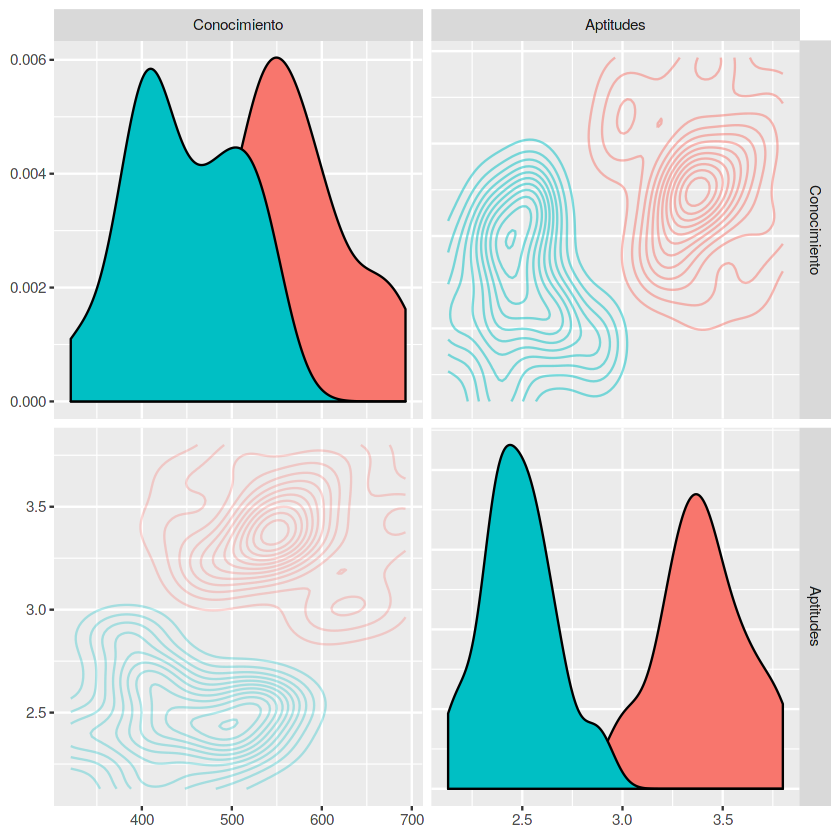

In [5]:
library(GGally)

 geom_fn <- function(data, mapping, ...){
    p <- ggplot(data = data, mapping = mapping) + 
        geom_hist(...)
    p
}

ggpairs(
    data = exp_ingreso[1:59,],
    columns = c('Conocimiento', 'Aptitudes'),    
    mapping = aes(color=as.factor(exp_ingreso$Resultado[1:59])),
    lower = list( # gráfico parte baja
        #continuous = wrap("density", alpha = 0.5), combo = "box"
        continuous = wrap("density", alpha = 0.3),
        combo = wrap("denstrip", alpha = 0.4)
    ),
    upper = list( # gráfico parte baja
        continuous = wrap("density", alpha = 0.5),
        combo = wrap("facethist", alpha = 0.4)
    ),
    #diag=list(continuous=wrap("barDiag"))   
)


Attaching package: 'cowplot'

The following object is masked from 'package:ggplot2':

    ggsave



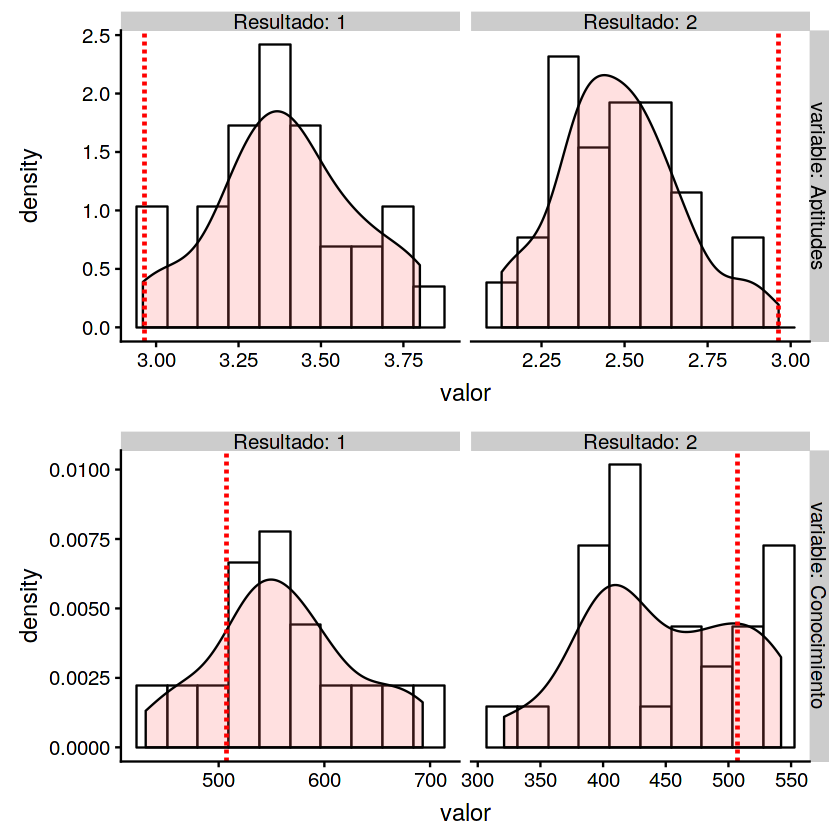

In [6]:
library(cowplot)

plt_actitudes <- exp_ingreso_long %>%
    filter(Resultado %in% c(1,2) & variable=="Aptitudes") %>%
    ggplot(aes(x=valor, fill=variable))+
        # Histogram with density instead of count on y-axis
        geom_histogram(            
            aes(y=..density..), colour="black", fill="white", bins=10
        ) +
        geom_density(alpha=.2, fill="#FF6666") +
        geom_vline(aes(xintercept=mean(valor, na.rm=T)),   # Ignore NA values for mean
                   color="red", linetype="dashed", size=1)+
        facet_grid(
            rows = vars(variable),
            cols = vars(Resultado),
            labeller = label_both,
            #scale="free"
            scales="free_x",
            #switch = 'x'
        )

plt_conocimiento <- exp_ingreso_long %>%
    filter(Resultado %in% c(1,2) & variable=="Conocimiento") %>%
    ggplot(aes(x=valor, fill=variable))+
        # Histogram with density instead of count on y-axis
        geom_histogram(            
            aes(y=..density..), colour="black", fill="white", bins=10
        ) +
        geom_density(alpha=.2, fill="#FF6666") +
        geom_vline(aes(xintercept=mean(valor, na.rm=T)),   # Ignore NA values for mean
                   color="red", linetype="dashed", size=1)+
        facet_grid(
            rows = vars(variable),
            cols = vars(Resultado),
            labeller = label_both,            
            scales="free_x",            
        )

plot_grid(plotlist = list(plt_actitudes, plt_conocimiento), ncol = 1, align = 'v')

In [7]:
# Shapiro-Wilco:
#  - Se rechaza Ho si W es muy pequeño.
#  - W oscila entre 0-1
#  - Si p_value es menor que 1-(porcentaje confianza) se rechaza Ho
exp_ingreso_long[,-1] %>%    
    filter(Resultado %in% c(1,2) ) %>%
    group_by(Resultado, variable) %>%
    summarise_all(
        .funs = list(
            W = ~shapiro.test(valor)$statistic, 
            p_value = ~shapiro.test(valor)$p.value)            
    )

Resultado,variable,W,p_value
<dbl>,<chr>,<dbl>,<dbl>
1,Aptitudes,0.9793201,0.7935037
1,Conocimiento,0.9775037,0.7402801
2,Aptitudes,0.9799643,0.8495519
2,Conocimiento,0.9462718,0.1595321


In [8]:
suppressWarnings(library(biotools))
exp_ingreso1 <- exp_ingreso[exp_ingreso$Resultado %in% c(1,2),-c(1)]
boxM(data=exp_ingreso1[,-1],group=exp_ingreso1$Resultado)

Loading required package: rpanel
Loading required package: tcltk
Package `rpanel', version 1.1-4: type help(rpanel) for summary information

Attaching package: 'rpanel'

The following object is masked from 'package:tidyr':

    population

Loading required package: tkrplot
Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: lattice
Loading required package: SpatialEpi
Loading required package: sp


---
biotools version 3.1



	Box's M-test for Homogeneity of Covariance Matrices

data:  exp_ingreso1[, -1]
Chi-Sq (approx.) = 1.0439, df = 3, p-value = 0.7906


In [9]:
library(dplyr)
exp_ingreso[,-1] %>%
    #filter(Resultado %in% c(1,2)) %>%
    group_by(Resultado) %>%
    summarise_all(
        .funs = funs(      
            cor_val = round(cor(Conocimiento,Aptitudes), 2)
        )
    )

Warning message:
"funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

  # Before:
  funs(name = f(.))

  # After: 
  list(name = ~ f(.))
This warning is displayed once per session."

Resultado,Conocimiento_cor_val,Aptitudes_cor_val
<dbl>,<dbl>,<dbl>
1,-0.04,-0.04
2,-0.10,-0.10
3,-0.66,-0.66


In [10]:
library(MASS)

# creamos el modelo
lda_exp_ingreso <- lda(
    formula = Resultado ~ Conocimiento + Aptitudes,
    data=exp_ingreso[,-1]
)

#attributes(lda_exp_ingreso)
lda_exp_ingreso

Call:
lda(Resultado ~ Conocimiento + Aptitudes, data = exp_ingreso[, 
    -1])

Prior probabilities of groups:
        1         2         3 
0.3647059 0.3294118 0.3058824 

Group means:
  Conocimiento Aptitudes
1     561.2258  3.398387
2     447.0714  2.482500
3     446.2308  2.992692

Coefficients of linear discriminants:
                      LD1         LD2
Conocimiento -0.008881605 -0.01431778
Aptitudes    -4.931238914  1.87356253

Proportion of trace:
   LD1    LD2 
0.9668 0.0332 

In [11]:
exp_ingreso_lda_pred <- predict(lda_exp_ingreso)
table(exp_ingreso_lda_pred$class)


 1  2  3 
29 27 29 

In [12]:
matriz_confusion<-as.matrix(table("Clase Real"=exp_ingreso$Resultado, "Clase Predicha"=exp_ingreso_lda_pred$class) )

In [13]:
library(caret)

# data = predicted
# reference = real
confusionMatrix(data=exp_ingreso_lda_pred$class, reference = as.factor(exp_ingreso$Resultado))

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 28  0  1
         2  0 26  1
         3  3  2 24

Overall Statistics
                                          
               Accuracy : 0.9176          
                 95% CI : (0.8377, 0.9662)
    No Information Rate : 0.3647          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8765          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.9032   0.9286   0.9231
Specificity            0.9815   0.9825   0.9153
Pos Pred Value         0.9655   0.9630   0.8276
Neg Pred Value         0.9464   0.9655   0.9643
Prevalence             0.3647   0.3294   0.3059
Detection Rate         0.3294   0.3059   0.2824
Detection Prevalence   0.3412   0.3176   0.3412
Balanced Accuracy      0.9424   0.9555   0.9192

In [14]:
exp_ingreso$Resultado

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
[39] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[77] 3 3 3 3 3 3 3 3 3

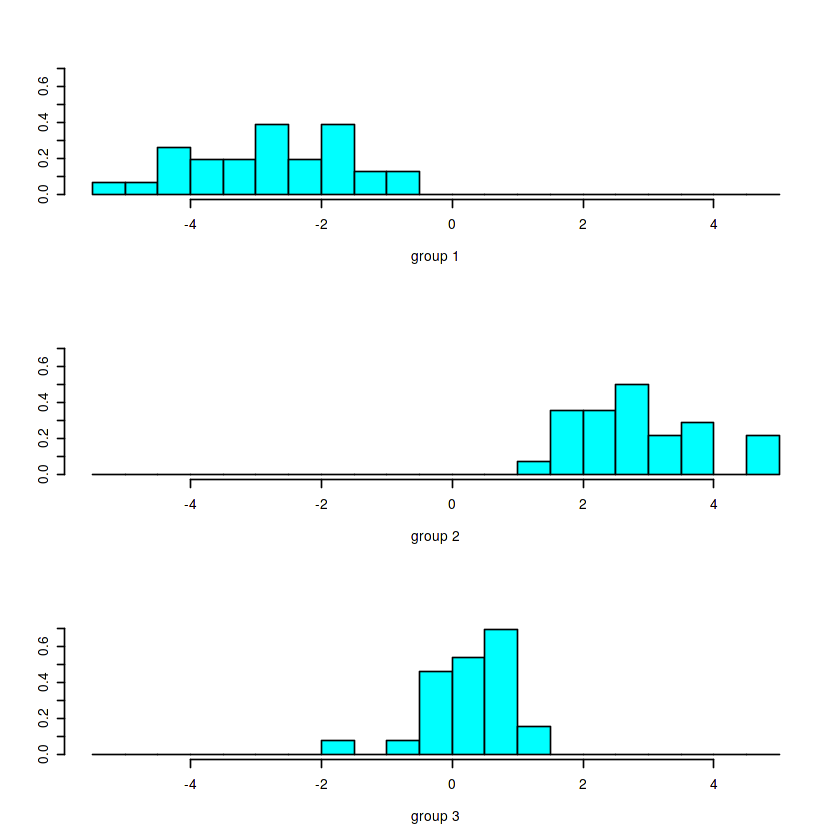

In [15]:
ldahist(data=exp_ingreso_lda_pred$x[,1], g=exp_ingreso$Resultado)

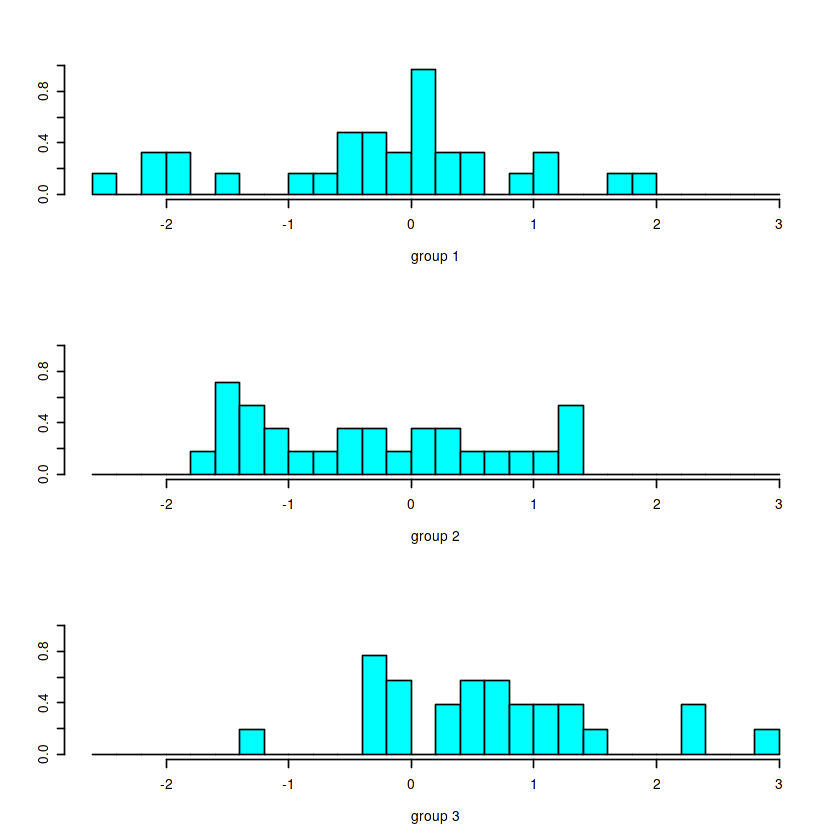

In [16]:
ldahist(data=exp_ingreso_lda_pred$x[,2], g=exp_ingreso$Resultado)

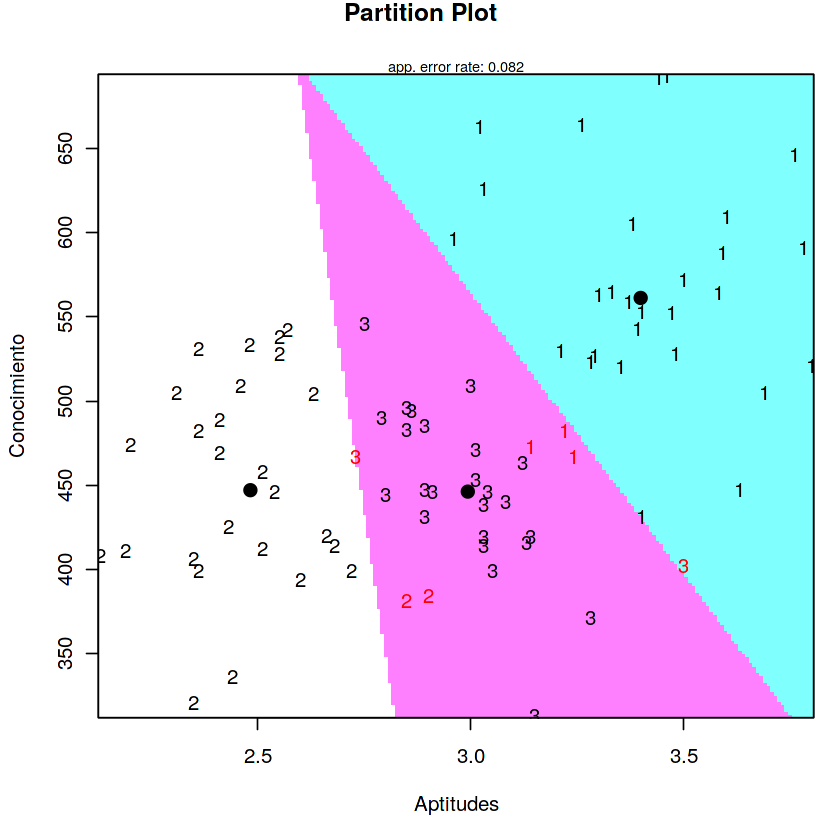

In [17]:
library(klaR)
exp_ingreso$Resultado <- factor(exp_ingreso$Resultado)
partimat(
    Resultado~Conocimiento+Aptitudes,
    data=exp_ingreso[,-1],
    method="lda",
    prec=200,
    name=c("Conocimiento", "Aptitudes")
)

In [18]:
exp_ingreso_nvos_casos <- read_excel("datasets/IngresoUniversidad_NvoCasos.xlsx", sheet="Hoja1")
exp_ingreso_nvos_casos <- as.data.frame(exp_ingreso_nvos_casos)


exp_ingreso_lda_pred_nvos <- predict(object=lda_exp_ingreso, newdata=exp_ingreso_nvos_casos)
exp_ingreso_lda_pred_nvos

$class
[1] 3 2 1
Levels: 1 2 3

$posterior
             1            2          3
1 0.0608741276 1.569535e-02 0.92343052
2 0.0001268638 6.381146e-01 0.36175850
3 0.9760684317 1.565286e-08 0.02393155

$x
         LD1         LD2
1 -0.2041607 -0.04971375
2  1.5795386 -0.22329949
3 -3.1627163  2.78529377

In [19]:
sc_obj <- greedy.wilks(formula= Resultado~Conocimiento+Aptitudes, data=exp_ingreso[exp_ingreso$Resultado %in% c(1,2),-1])
sc_obj

Formula containing included variables: 

Resultado ~ Aptitudes
<environment: 0x8f5bba8>


Values calculated in each step of the selection procedure: 

       vars Wilks.lambda F.statistics.overall p.value.overall F.statistics.diff
1 Aptitudes    0.1580097             303.7374    1.661717e-24          303.7374
  p.value.diff
1 1.661717e-24

In [20]:
exp_ingreso_lda_pred_nvos

$class
[1] 3 2 1
Levels: 1 2 3

$posterior
             1            2          3
1 0.0608741276 1.569535e-02 0.92343052
2 0.0001268638 6.381146e-01 0.36175850
3 0.9760684317 1.565286e-08 0.02393155

$x
         LD1         LD2
1 -0.2041607 -0.04971375
2  1.5795386 -0.22329949
3 -3.1627163  2.78529377